In the past couple classes we’ve seen the utility of generating ${x_i}$ according to a *pdf* $f(x)dx$.  We explored some ways to do this using the *direct* and *acceptance-rejection methods*.  We can also do this using Markov Chains. A **Markov Chain** is a sequence of $\vec{x}_1,\vec{x}_2,\ldots,\vec{x}_n,\ldots$ where $\vec{x}_{n+1}$ depends only on $\vec{x}_n$. We can guess how this might work by mimicking a random walk.

1. Pick arbitrary $x_1$  as a starting point.
2. Decide on $x_2$  based on a proposal.  An example proposal could be to pick $x_2\in[x_1−\Delta x,x_1+\Delta x]$, where $\Delta x$ is a (uniform) random number.  Note that this proposal is symmetric, i.e. $P\left(x_1\rightarrow x_2\right)= P\left(x_2\rightarrow x_1\right)$.

Let's see how a uniform distribution can be sampled by a random walk around the space.

In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

In [2]:
step_size = 0.1 ## pick a value not too big or too small
x = [rand.random()] ## store location after each step, initialize to random value on [0,1]
N = 20 ## let's start with a small number to visualize
for _ in range(N):
    prop = x[-1]-step_size*(1.-2*rand.random()) ## propose new value
    if prop < 0 or prop > 1: x.append(x[-1]) ## STOP! No need to go that way, stay put and store location.
    else: x.append(prop) ## otherwise take step and store new location

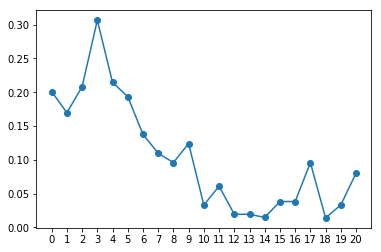

In [3]:
## plot step number vs location
fig,ax=plt.subplots()
ax.plot(np.arange(np.size(x)),x,'o-')
_ = ax.set_xticks(np.arange(np.size(x)))
#ax.set_xticklabels(['zero','two','four','six']))

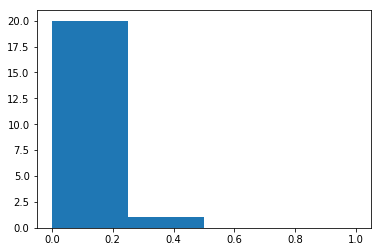

In [4]:
## or as a histogram (losing "time" info)
fig,ax = plt.subplots()
counts,bins,_ = ax.hist(x,bins=np.linspace(0,1,5))

Doesn't look very uniform, but we only took 20 steps.  Let's try taking a larger number, say 100k.

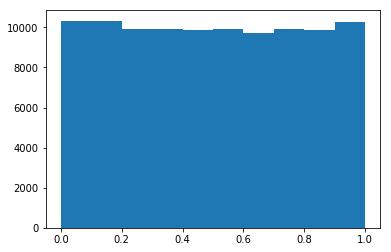

In [11]:
x = [rand.random()] ## store location after each step, initialize to random value on [0,1]
N=10**5
for _ in range(N):
    prop = x[-1]-step_size*(1.-2*rand.random()) ## propose new value
    if prop < 0 or prop > 1: x.append(x[-1]) ## STOP! No need to go that way, stay put and store location.
    else: x.append(prop) ## otherwise take step and store new location
        
fig,ax = plt.subplots()
counts,bins,_ = ax.hist(x)

Looks uniform.  In the case of the random walk above, we just repeated these steps over and over.  Metropolis improved on this by introducing an acceptance criteria.  The procedure is to calculate a=min$\big(\frac{f(x_2^{prop})}{f(x_1)},1\big)$, pick a uniform random number $z\in[0,1]$, and reject the proposal if $z>a$, i.e. if accepted, $x_2=x_2^{prop}$  and if not $x_2=x_1$.  After many samplings, the resulting sequence is a good sampling of $f(x)$.

Some things to note:

1. The starting point is arbitrary.
2. The starting point must be chosen so that $f(x_1 )>0$.
3. The beginning part of the generated sequence is determined by the starting point.  Thus, it is good practice to throw away the beginning of the chain.  This is referred to as ``burn in’’.
4. The normalization of $f(x)$ is not needed since we are only taking ratios.
5. The proposal function can be any function as long as it is non-zero on the domain of validity of $f(x)$.
6. Metropolis employs a symmetric proposal.

Let's implement a simple Metropolis algorithm to sample a Gaussian distribution with $\mu=3$ and $\sigma=1.5$.

In [30]:
def f(x,mu,sigma):
    return np.exp(-(x-mu)**2/2/sigma**2) ## normalization cancels in the ratio

mu=3
sigma=1.5
N = 10**5
step_size = 0.1
x = [mu]
for i in range(N):
    xnew = x[-1]-step_size*(1-2*rand.random())
    ratio = f(xnew,mu,sigma)/f(x[-1],mu,sigma)
    if rand.random() < ratio: x.append(xnew)
    else: x.append(x[-1])

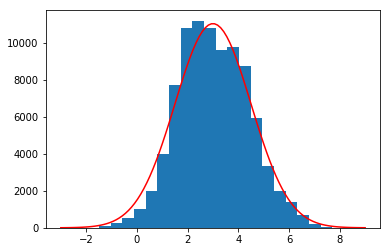

In [31]:
nburn = 10**4
fig,ax = plt.subplots()
counts,bins,_ = ax.hist(x[nburn:],bins=20)
bin_widths = bins[1:]-bins[:-1]
int_hist = np.sum(bin_widths*counts)
xvals = np.linspace(-3,9,100)
plt.plot(xvals,(1./np.sqrt(2*np.pi*sigma**2))*f(xvals,mu,sigma)*int_hist,'r-')

Many problems in physics involve performing integrals of sharply peaked distributions.  In the homework, you will use Metropois to study the Ising Model in one dimension.  Here we consider a (quantum) harmonic oscillator in the path integral formalism.

In [35]:
def d(u):
    global kappa
    return u/np.sqrt(1+kappa)

def dsq(u):
    global kappa
    return u/(1+kappa)

def x(u):
    global kappa, m, epsilon, hbar
    return np.sqrt(epsilon*hbar/m)*d(u)

def xsq(u):
    global kappa, m, epsilon, hbar
    return (epsilon*hbar/m)*dsq(u)

In [38]:
m = 1.
k = 1.
epsilon = 1.
omega = np.sqrt(k/m)
kappa = 0.25 * omega * omega * epsilon * epsilon
g = (1-kappa)/(1+kappa)
Delta = 1.
hbar = 1.

ntimes = 10**3
npasses = 10**3

locations = np.zeros(ntimes+1)
avg = []
avg.append(0)
avg_sq = []
avg_sq.append(0)

for i in range(1,npasses):
    for time in range(1,ntimes):
        delta = Delta * rand.uniform(-1,1)
        deltaS = delta * (delta + 2*locations[time] - g * (locations[time-1] + locations[time+1]))
        if (rand.random() < np.exp(-deltaS)):
            locations[time] += delta
        else:
            locations[time] = locations[time-1]
    avg.append(x(np.average(locations)))
    avg_sq.append(xsq(np.average(locations*locations)))

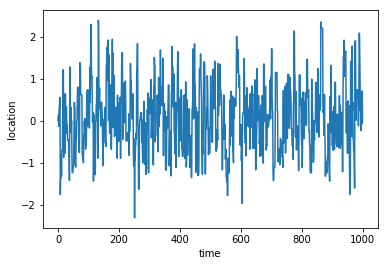

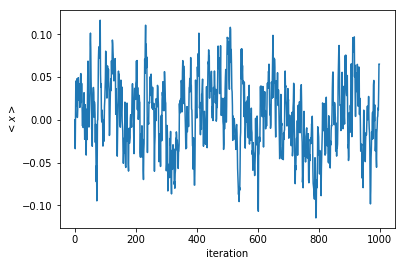

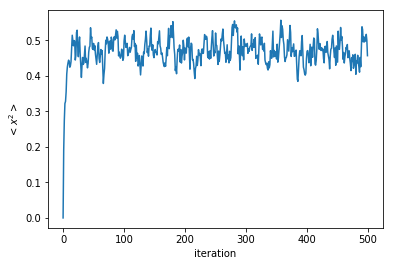

In [39]:
times = np.array(np.arange(0,ntimes+1))
plt.plot(times,locations)
plt.xlabel('time')
plt.ylabel('location')
plt.show()

times = np.array(np.arange(0,ntimes))
avg = np.array(avg)
plt.plot(times,avg)
plt.xlabel('iteration')
plt.ylabel('$<x>$')
plt.show()

avg_sq = np.array(avg_sq)
plt.plot(times[:500],avg_sq[:500])
plt.xlabel('iteration')
plt.ylabel('$<x^{2}>$')
plt.show()